In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt


In [3]:
# Fonction pour l'évaluation du modèle
def evaluate_model(model, X_val: np.ndarray, y_val: np.ndarray):
    predictions = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_val, predictions),
        "Precision": precision_score(y_val, predictions, zero_division=0),
        "Recall": recall_score(y_val, predictions, zero_division=0),
        "F1-score": f1_score(y_val, predictions, zero_division=0),
        "ROC-AUC": roc_auc_score(y_val, probs) if probs is not None else "N/A"
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")


In [5]:
# Classe pour l'optimisation du modèle RandomForest avec une approche métaheuristique
class RandomForestOptimizer:
    def __init__(self, param_ranges):
        self.param_ranges = param_ranges

    def params_from_solution(self, solution: np.ndarray):
        params = {}
        for i, (param_name, (min_val, max_val)) in enumerate(self.param_ranges.items()):
            params[param_name] = int(solution[i] * (max_val - min_val) + min_val)
        return params

    def objective_function(self, solution: np.ndarray, X_train, y_train, X_val, y_val):
        model = RandomForestClassifier(**self.params_from_solution(solution))
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        return 1 - accuracy_score(y_val, predictions)

    def optimize(self, population: np.ndarray, X_train: np.ndarray, y_train: np.ndarray,
                 X_val: np.ndarray, y_val: np.ndarray, iterations: int = 10) -> np.ndarray:
        print('Starting MLBO optimization..')
        population = population.copy()

        fitness = [self.objective_function(p, X_train, y_train, X_val, y_val) for p in population]
        leader = population[np.argmin(fitness)].copy()
        print(f'Initial leader fitness: {min(fitness):.4f}')

        best_fitness_history = []

        for iteration in range(iterations):
            print(f'Iteration {iteration + 1}/{iterations}...')
            new_leader = 0.5 * leader + 0.5 * population[np.random.randint(0, len(population))]

            for i in range(len(population)):
                distance = np.linalg.norm(population[i] - new_leader)
                step_size = distance / 2
                new_solution = population[i] + step_size * (new_leader - population[i])
                population[i] = np.clip(new_solution, 0, 1)

            fitness = [self.objective_function(p, X_train, y_train, X_val, y_val) for p in population]
            best_index = np.argmin(fitness)
            current_best_fitness = fitness[best_index]
            best_fitness_history.append(current_best_fitness)

            print(f'Best fitness in iteration {iteration + 1}: {current_best_fitness:.4f}')
            if current_best_fitness < self.objective_function(leader, X_train, y_train, X_val, y_val):
                leader = population[best_index].copy()

        # Visualiser la progression de l'optimisation
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, iterations + 1), best_fitness_history, 'b-')
        plt.title('Optimization Progress')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness (1 - Accuracy)')
        plt.grid(True)
        plt.show()

        # Évaluer la meilleure solution
        best_params = self.params_from_solution(leader)
        best_model = RandomForestClassifier(**best_params)
        best_model.fit(X_train, y_train)
        print("\nOptimization Complete.")
        print("Best Parameters:", best_params)
        print("\nEvaluation Metrics:")
        evaluate_model(best_model, X_val, y_val)

        return population, best_model

In [7]:
file_path = r'C:\Users\pc\Downloads\fake profile detection datasets\csv_result-Twitter_dataset.xlsx'
data = pd.ExcelFile(file_path).parse('csv_result-Twitter_dataset')
print(data.columns)


Index(['id', 'protected', 'followers_count', 'friends_count',
       'favourites_count', 'profile_use_background_image', 'hashtags_average',
       'mentions_average', 'urls_average', 'description', 'statuses_count',
       'listed_count', 'verified', 'contributors_enabled', 'default_profile',
       'default_profile_image', 'is_translator', 'is_fake'],
      dtype='object')


In [9]:
# Nettoyer les noms de colonnes (enlever les guillemets et espaces)
data.columns = data.columns.str.replace("''", '', regex=True).str.strip()

# Afficher les colonnes après nettoyage
print(data.columns)


Index(['id', 'protected', 'followers_count', 'friends_count',
       'favourites_count', 'profile_use_background_image', 'hashtags_average',
       'mentions_average', 'urls_average', 'description', 'statuses_count',
       'listed_count', 'verified', 'contributors_enabled', 'default_profile',
       'default_profile_image', 'is_translator', 'is_fake'],
      dtype='object')


In [11]:
# Nettoyage des données : suppression des colonnes inutiles
columns_to_drop = ['id', 'description']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data_cleaned = data.drop(columns=columns_to_drop)

# Vérification des colonnes après nettoyage
print("Colonnes après nettoyage :")
print(data_cleaned.columns)

# Affichage des 5 premières lignes
print("Exemple de données nettoyées :")
print(data_cleaned.head())


Colonnes après nettoyage :
Index(['protected', 'followers_count', 'friends_count', 'favourites_count',
       'profile_use_background_image', 'hashtags_average', 'mentions_average',
       'urls_average', 'statuses_count', 'listed_count', 'verified',
       'contributors_enabled', 'default_profile', 'default_profile_image',
       'is_translator', 'is_fake'],
      dtype='object')
Exemple de données nettoyées :
   protected  followers_count  friends_count  favourites_count  \
0      False             2232            414              4227   
1      False               19            128               479   
2      False              121             53              1567   
3      False             4112            710              1129   
4      False              304            175              3424   

   profile_use_background_image  hashtags_average  mentions_average  \
0                          True              0.10              0.85   
1                          True              0

In [13]:
# Remplissage des valeurs manquantes : avec 0 pour les colonnes numériques
data_cleaned['followers_count'] = data_cleaned['followers_count'].fillna(0)
data_cleaned['friends_count'] = data_cleaned['friends_count'].fillna(0)
data_cleaned['favourites_count'] = data_cleaned['favourites_count'].fillna(0)



In [15]:
# Définir les colonnes catégorielles et numériques
categorical_columns = ['protected', 'profile_use_background_image', 'verified', 'contributors_enabled', 
                       'default_profile', 'default_profile_image', 'is_translator', 'is_fake']
numeric_columns = ['followers_count', 'friends_count', 'favourites_count', 'hashtags_average', 
                   'mentions_average', 'urls_average', 'statuses_count', 'listed_count']


In [17]:

# Remplir les valeurs manquantes pour les colonnes catégorielles avec 'Unknown'
for col in categorical_columns:
    # Remplissage des valeurs manquantes pour les colonnes catégorielles avec 'Unknown'
    data_cleaned[col] = data_cleaned[col].fillna('Unknown')



In [19]:
# Créer le dataset transformé avec les variables catégorielles encodées
data_processed = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

# Standardisation des colonnes numériques
scaler = StandardScaler()
data_processed[numeric_columns] = scaler.fit_transform(data_processed[numeric_columns])


In [21]:
print(data_processed.columns)


Index(['followers_count', 'friends_count', 'favourites_count',
       'hashtags_average', 'mentions_average', 'urls_average',
       'statuses_count', 'listed_count', 'protected_True',
       'profile_use_background_image_True', 'verified_True',
       'default_profile_True', 'default_profile_image_True', 'is_fake_True'],
      dtype='object')


In [23]:
# Séparer les variables indépendantes (X) et la cible (y)
X = data_processed.drop(columns=['is_fake_True'])
y = data_processed['is_fake_True']



Selected features: Index(['friends_count', 'favourites_count', 'hashtags_average',
       'mentions_average', 'urls_average', 'statuses_count', 'protected_True',
       'profile_use_background_image_True', 'default_profile_True',
       'default_profile_image_True'],
      dtype='object')
Starting MLBO optimization..
Initial leader fitness: 0.0952
Iteration 1/10...
Best fitness in iteration 1: 0.1000
Iteration 2/10...
Best fitness in iteration 2: 0.1000
Iteration 3/10...
Best fitness in iteration 3: 0.1048
Iteration 4/10...
Best fitness in iteration 4: 0.1048
Iteration 5/10...
Best fitness in iteration 5: 0.1048
Iteration 6/10...
Best fitness in iteration 6: 0.1048
Iteration 7/10...
Best fitness in iteration 7: 0.1048
Iteration 8/10...
Best fitness in iteration 8: 0.1048
Iteration 9/10...
Best fitness in iteration 9: 0.1048
Iteration 10/10...
Best fitness in iteration 10: 0.1048


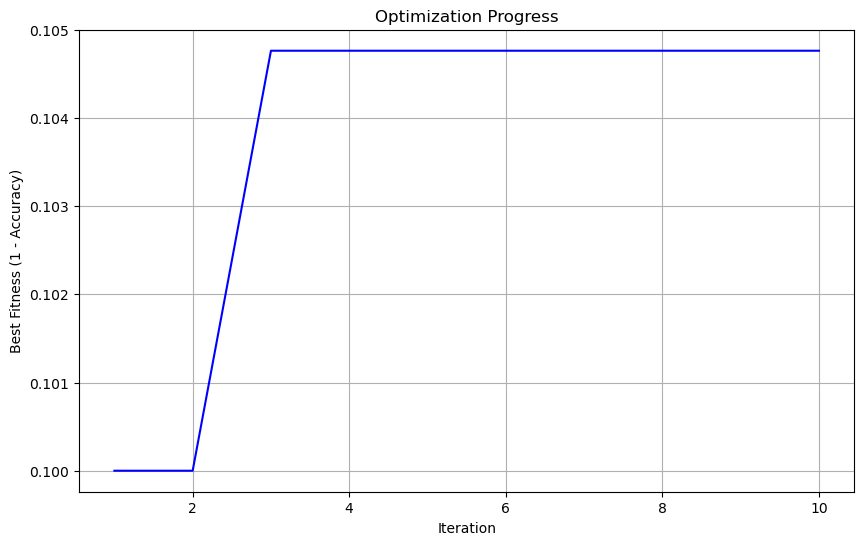


Optimization Complete.
Best Parameters: {'n_estimators': 113, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}

Evaluation Metrics:
Accuracy: 0.8857
Precision: 0.8785
Recall: 0.8952
F1-score: 0.8868
ROC-AUC: 0.9617

Final Evaluation on Test Set:
Accuracy: 0.9133
Precision: 0.9156
Recall: 0.9156
F1-score: 0.9156
ROC-AUC: 0.9706


<Figure size 1000x600 with 0 Axes>

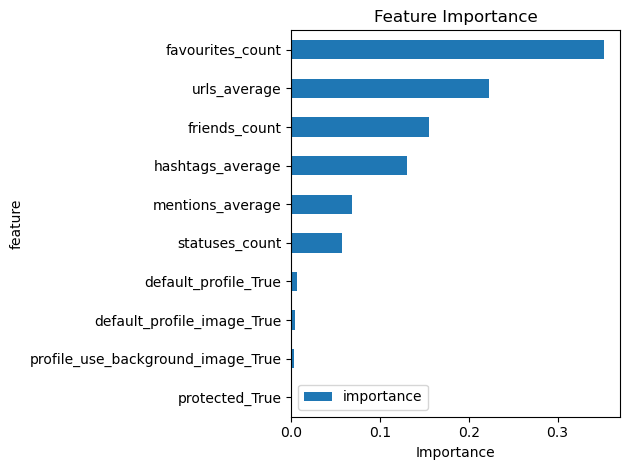

In [60]:




# Créer le dataset transformé avec les variables catégorielles encodées
data_processed = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

# Standardisation des colonnes numériques
scaler = StandardScaler()
data_processed[numeric_columns] = scaler.fit_transform(data_processed[numeric_columns])

# Séparer les variables indépendantes (X) et la cible (y)
X = data_processed.drop(columns=['is_fake_True'])
y = data_processed['is_fake_True']
# Sélection des caractéristiques
selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new = selector.fit_transform(X, y)
selected_columns = X.columns[selector.get_support()]
print("\nSelected features:", selected_columns)

# Mise à jour des colonnes sélectionnées pour le dataframe X
X = pd.DataFrame(X_new, columns=selected_columns)

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Définir les plages de paramètres pour l'optimisation
param_ranges = {
    'n_estimators': (50, 200),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

# Initialiser l'optimiseur
optimizer = RandomForestOptimizer(param_ranges)

# Générer une population initiale pour l'optimisation
population_size = 40
population = np.random.random((population_size, len(param_ranges)))

# Lancer l'optimisation
final_population, best_model = optimizer.optimize(
    population=population,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    iterations=10
)

# Évaluation finale sur l'ensemble de test
print("\nFinal Evaluation on Test Set:")
evaluate_model(best_model, X_test, y_test)

# Visualisation de l'importance des fonctionnalités
feature_importance = pd.DataFrame({
    'feature': selected_columns,
    'importance': best_model.feature_importances_
})

plt.figure(figsize=(10, 6))
feature_importance.sort_values('importance', ascending=True).plot(x='feature', y='importance', kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
